## DAT540 Project
## Group 8 - Solar Radiation prediction

### Group members
- Daniel Dura, Amin Elmenshawy, Rza Behbudov -> equal contribution on the project
- Aigul Akberova, Malik Bilal -> ML model contribution Gradient Boosting and Decision Trees/Linear Regression.
                              

### Problem statement

The dataset contains such columns as: "wind direction", "wind speed", "humidity" and temperature. 
The response parameter that is to be predicted is: ***"Solar_radiation"*** which contains measurements for the past 4 months and you have to predict the level of solar radiation.

### Dataset

These dataset covers meteorological data from the HI-SEAS weather station from four months (September through December 2016) between Mission IV and Mission V.

For each dataset, the fields are:

- A row number (1-n) useful in sorting this export's results
- The UNIX time_t date (seconds since Jan 1, 1970). Useful in sorting this export's results with other export's results
- The date in yyyy-mm-dd format
- The local time of day in hh:mm:ss 24-hour format
- The numeric data, if any (may be an empty string)
- The text data, if any (may be an empty string)

The units of each dataset are:

Solar radiation: ***watts per meter^2***

Temperature: ***degrees Fahrenheit***

Humidity: ***percent***

Barometric pressure: ***Hg***

Wind direction: ***degrees***

Wind speed: ***miles per hour***

Sunrise/sunset: ***Hawaii time***

In [56]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
import missingno 
from pytz import timezone
import pytz
import re
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.ensemble import IsolationForest
from datetime import datetime
from datetime import timedelta 
import tensorflow as tf
from tensorflow.keras import backend as K
import random

In [57]:
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.utils import class_weight
from sklearn.utils.extmath import density
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVR
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from time import time

## Data cleaning and preprocessing

In [58]:
df = pd.read_csv('SolarPrediction.csv')
df.head()

UNIXTime                   Data      Time  Radiation  Temperature  \
0  1475229326  9/29/2016 12:00:00 AM  23:55:26       1.21           48   
1  1475229023  9/29/2016 12:00:00 AM  23:50:23       1.21           48   
2  1475228726  9/29/2016 12:00:00 AM  23:45:26       1.23           48   
3  1475228421  9/29/2016 12:00:00 AM  23:40:21       1.21           48   
4  1475228124  9/29/2016 12:00:00 AM  23:35:24       1.17           48   

   Pressure  Humidity  WindDirection(Degrees)  Speed TimeSunRise TimeSunSet  
0     30.46        59                  177.39   5.62    06:13:00   18:13:00  
1     30.46        58                  176.78   3.37    06:13:00   18:13:00  
2     30.46        57                  158.75   3.37    06:13:00   18:13:00  
3     30.46        60                  137.71   3.37    06:13:00   18:13:00  
4     30.46        62                  104.95   5.62    06:13:00   18:13:00

From these we can see that 4 datetime columns are strings instead of datetime objects

In [59]:
df.describe()

UNIXTime     Radiation   Temperature      Pressure      Humidity  \
count  3.268600e+04  32686.000000  32686.000000  32686.000000  32686.000000   
mean   1.478047e+09    207.124697     51.103255     30.422879     75.016307   
std    3.005037e+06    315.916387      6.201157      0.054673     25.990219   
min    1.472724e+09      1.110000     34.000000     30.190000      8.000000   
25%    1.475546e+09      1.230000     46.000000     30.400000     56.000000   
50%    1.478026e+09      2.660000     50.000000     30.430000     85.000000   
75%    1.480480e+09    354.235000     55.000000     30.460000     97.000000   
max    1.483265e+09   1601.260000     71.000000     30.560000    103.000000   

       WindDirection(Degrees)         Speed  
count            32686.000000  32686.000000  
mean               143.489821      6.243869  
std                 83.167500      3.490474  
min                  0.090000      0.000000  
25%                 82.227500      3.370000  
50%                147.700000      5.620000  
75%                179.310000      7.870000  
max                359.950000     40.500000

There is notably a large difference between 75th %tile and max values of radiation and wind direction.
These observations suggest that there are extreme values-Outliers in our data set.


<AxesSubplot:>

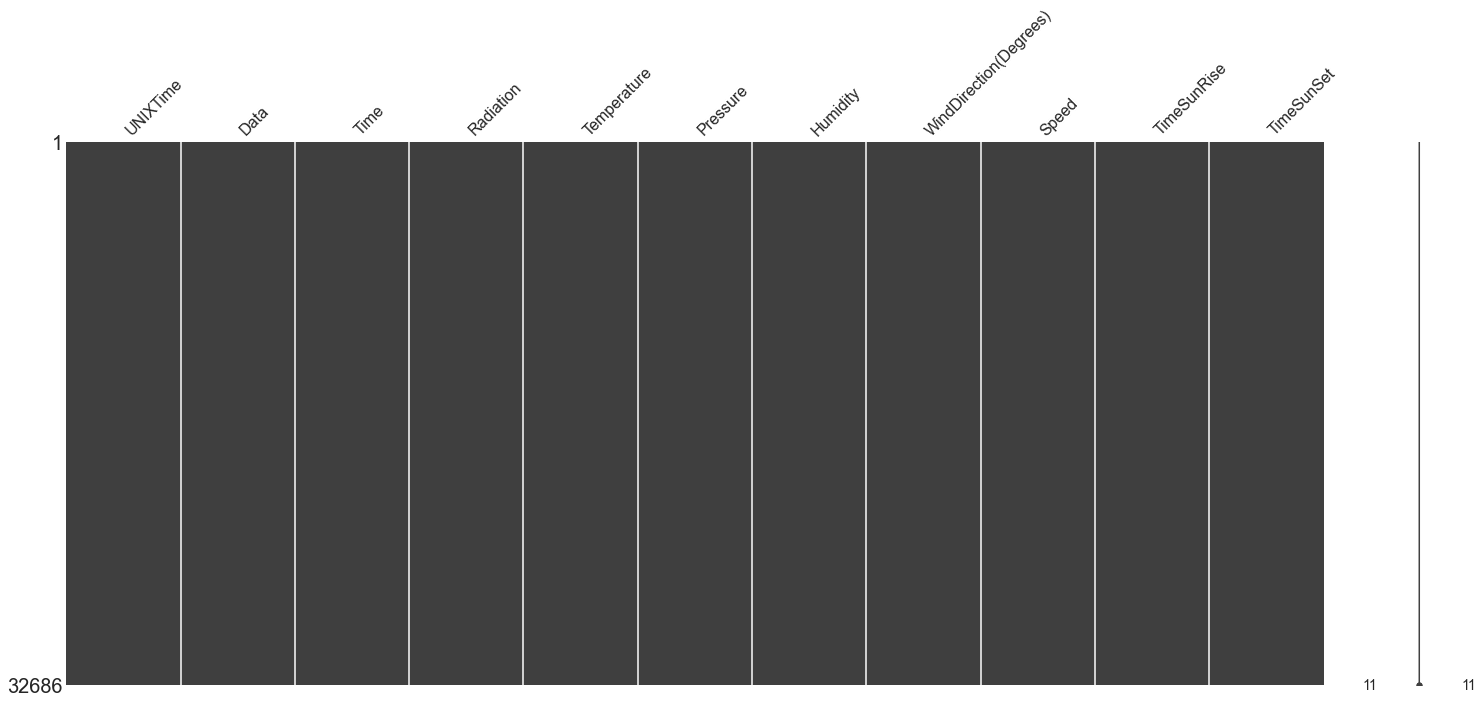

In [60]:
missingno.matrix(df)

As we can see we don't have any missing values in the provided dataset.

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


In [62]:
def preprocess_data(df):

    """
    Description:
        Convert timezone to Hawaii
        Rename some of the columns
        Convert string columns to datetime objects
    
    Args:
        val: input df (DataFrame)
        
    Returns:
        df -> preprocessed DataFrame
    """

    #'Data' - all elements contain the same value.
    #we have UNIXTime so we can drop Time.
    df.drop(['Data','Time'],axis=1,inplace=True)

    # index by UNIX time
    df['UNIXTime'] = pd.to_datetime(df['UNIXTime'], unit='s')
    df.sort_values('UNIXTime', inplace=True) # sort by UNIXTime
    df.set_index('UNIXTime',inplace=True) # index by UNIXTime
    
     # Localize the index (using tz_localize) to UTC (to make the Timestamps timezone-aware) and then convert to Eastern (using tz_convert)
    hawaii= timezone('Pacific/Honolulu')
    df.index = df.index.tz_localize(pytz.utc).tz_convert(hawaii)

    #rename some of the columns
    df.rename(columns={'WindDirection(Degrees)': 'WindDirection', 'Speed': 'WindSpeed'}, inplace=True)

    #convert string columns to datetime objects
    df['day_of_month'] = df.index.day
    df['week_of_year'] = df.index.week
    df['month'] = df.index.month
    df['hour'] = df.index.hour 
    df['Date'] = df.index.date
    
    return df

In [63]:
df = preprocess_data(df)
df.head()

<ipython-input-62-986b552d9b54>:34: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



Radiation  Temperature  Pressure  Humidity  \
UNIXTime                                                                
2016-09-01 00:00:08-10:00       2.58           51     30.43       103   
2016-09-01 00:05:10-10:00       2.83           51     30.43       103   
2016-09-01 00:20:06-10:00       2.16           51     30.43       103   
2016-09-01 00:25:05-10:00       2.21           51     30.43       103   
2016-09-01 00:30:09-10:00       2.25           51     30.43       103   

                           WindDirection  WindSpeed TimeSunRise TimeSunSet  \
UNIXTime                                                                     
2016-09-01 00:00:08-10:00          77.27      11.25    06:07:00   18:38:00   
2016-09-01 00:05:10-10:00         153.44       9.00    06:07:00   18:38:00   
2016-09-01 00:20:06-10:00         142.04       7.87    06:07:00   18:38:00   
2016-09-01 00:25:05-10:00         144.12      18.00    06:07:00   18:38:00   
2016-09-01 00:30:09-10:00          67.42      11.25    06:07:00   18:38:00   

                           day_of_month  week_of_year  month  hour        Date  
UNIXTime                                                                        
2016-09-01 00:00:08-10:00             1            35      9     0  2016-09-01  
2016-09-01 00:05:10-10:00             1            35      9     0  2016-09-01  
2016-09-01 00:20:06-10:00             1            35      9     0  2016-09-01  
2016-09-01 00:25:05-10:00             1            35      9     0  2016-09-01  
2016-09-01 00:30:09-10:00             1            35      9     0  2016-09-01

## Exploratory Data Analysis

In this stage we perform initial investigations on the dataset in order to discover patterns, spot anomalies,test hypothesis and to check assumptions with the help of summary statistics and graphical representations.

In [64]:
fig = make_subplots(rows=3, cols=2)
Radiation = go.Histogram(x=df.Radiation, name='Radiation')
Temperature = go.Histogram(x=df.Temperature, name='Temperature')
Pressure = go.Histogram(x=df.Pressure, name='Pressure')
Humidity = go.Histogram(x=df.Humidity,name='Humidity')
#Speed = go.Histogram(x=df.Speed)
WindDirection = go.Histogram(x=df["WindDirection"],name='WindDirection')
fig.append_trace(Radiation, 1, 1)
fig.append_trace(Temperature, 1, 2)
fig.append_trace(Pressure, 2, 1)
fig.append_trace(Humidity, 2, 2)
#fig.append_trace(Speed, 3, 1)
fig.append_trace(WindDirection, 3, 1)
fig.show()

We notice that Pressure and and Temperature follow a normal distribution whereas Radiation and Humidity follow a right-skewed and left-skewed distribution.

<AxesSubplot:xlabel='Temperature', ylabel='Humidity'>

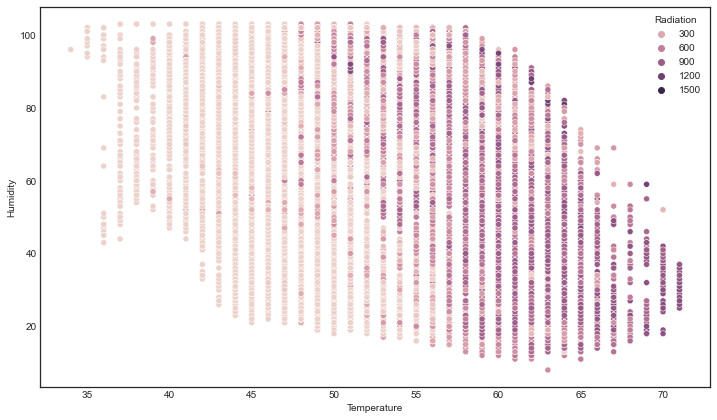

In [65]:
plt.figure(figsize=(12,7))
sns.scatterplot(x=df.Temperature, y=df.Humidity ,hue=df.Radiation)

High temperature and low humidity values corresponds to high radiation values.

In [66]:
fig = px.scatter_matrix(df,
    dimensions=["Temperature", "Pressure", "Humidity"],
    color="Radiation")
fig.show()

We can notice different correlation patterns between columns:
- positive correlation between pressure and temperature
- with high pressure and high temperature we have high radiation values
- negative correlation between temperature and humidity 

<AxesSubplot:>

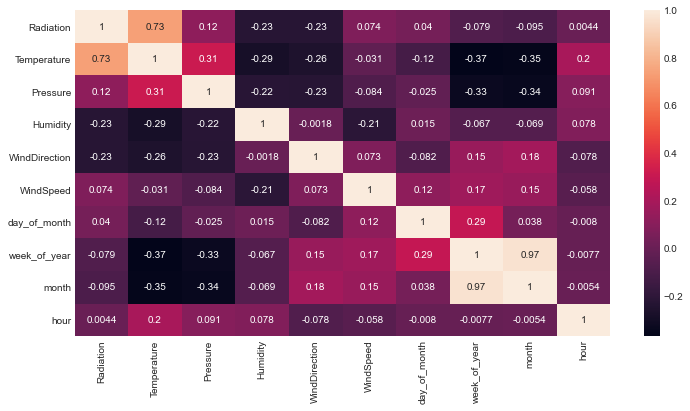

In [67]:
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(),annot=True)

We also tried to check the correlation between these 3 columns by only looking at one day in the dataset (2nd of September)

In [68]:
fig = px.scatter_matrix(df[(df.index.month==9) & (df.index.day==2)],
    dimensions=["Temperature", "Pressure", "Humidity"],
    color="Radiation")
fig.show()

In [69]:
x = df.index[(df.index.month==11)]
y1= df.Radiation[(df.index.month==11)].values
y2= df.Temperature[(df.index.month==11)].values
y3 = df.Pressure[(df.index.month==11)].values
y4 = df.Humidity[(df.index.month==11)].values


fig = make_subplots(rows=3, cols=2)
Radiation = go.Line(x=x, y=y1,name='Radiation')
Temperature = go.Line(x=x, y=y2,name='Temperature')
Pressure = go.Line(x=x, y=y3,name='Pressure')
Humidity = go.Line(x=x, y=y4,name='Humidity')


fig.append_trace(Radiation, 1, 1)
fig.append_trace(Temperature, 2, 1)
fig.append_trace(Pressure, 1, 2)
fig.append_trace(Humidity, 2, 2)


fig.show()

C:\Users\ndani\AppData\Local\Programs\Python\Python39\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




Text(0.5, 0, 'Date')

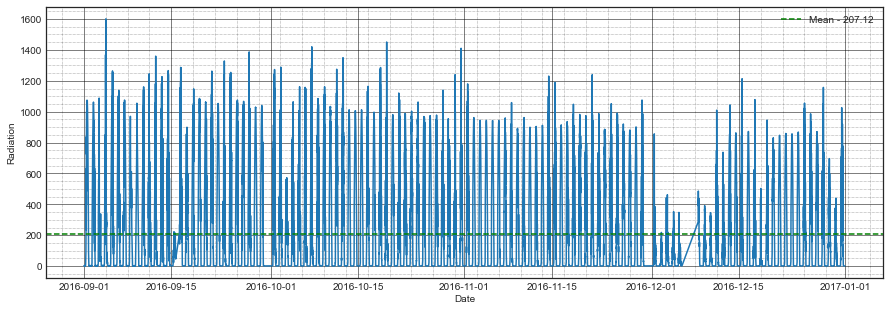

In [70]:
f, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=df, x=df.index, y="Radiation")
mean_avg=df['Radiation'].mean()
ax.axhline(mean_avg, color='green', linestyle='--', label=f"Mean - {mean_avg:.2f}")
ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth=0.5, color='black',)
ax.grid(which='minor', linestyle=':', linewidth=0.5, color='black', alpha=0.7)
ax.legend();
ax.set_xlabel('Date')

From the above plot we can notice some missing dates, 30th of September and November, 6th and 7th of December with an overall mean radiation value of 207.12

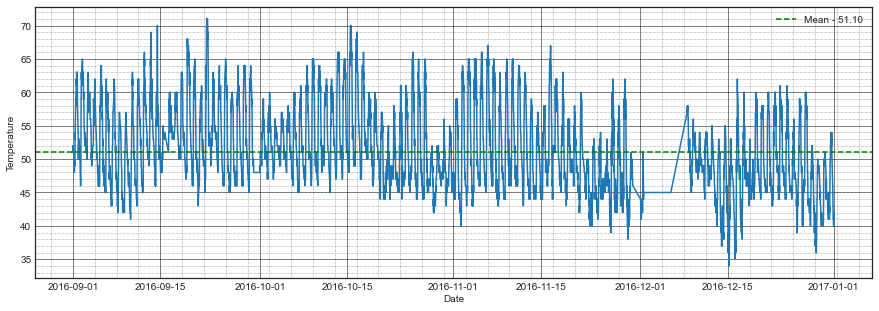

In [71]:
f, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=df, x=df.index, y="Temperature")
mean_avg=df['Temperature'].mean()
ax.axhline(mean_avg, color='green', linestyle='--', label=f"Mean - {mean_avg:.2f}")
ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth=0.5, color='black',)
ax.grid(which='minor', linestyle=':', linewidth=0.5, color='black', alpha=0.7)
ax.set_xlabel('Date')
ax.legend();

The average temperature for the hole dataset is 51.10 degrees and we can notice that the change in seasons from summer ( September-October) to winter (November-January) corresponds to a decrease in radiation values.

In [72]:
import datetime 
from datetime import timedelta 

In [73]:
def missing_dates(data):
    """
    Description:
        select the first and last date
        count the number of days between these two dates
        check with dates are in all_dates but not in dates by using a for loop with range and adding these dates to dates_missing
    
    Args:
        val: input data (DataFrame)
        
    Returns:
        dates_missing -> lst
    """
    
    data.reset_index(inplace=True)
    data.set_index('Date',inplace=True)
    data.index = pd.to_datetime(data.index)
    
    #select the first and last date
    start_date = data.index[0]
    end_date = data.index[len(data.index)-1]

    #count the number of days between these two dates:
    numdays = (end_date - start_date).days
    
    #create a new list with all dates between start_date and end_date:
    all_dates = []
    for x in range (0, (numdays+1)):
        all_dates.append(start_date + datetime.timedelta(days = x))
    
    dates_missing = []

    #check with dates are in all_dates but not in dates by using a for loop with range and adding these dates to dates_missing:
    for i in range (0, len(all_dates)):
        if (all_dates[i] not in data.index):
            dates_missing.append(all_dates[i])
        else:
            pass
    
    return dates_missing

In [74]:
missing_dates(df)

[Timestamp('2016-09-30 00:00:00'),
 Timestamp('2016-11-30 00:00:00'),
 Timestamp('2016-12-06 00:00:00'),
 Timestamp('2016-12-07 00:00:00')]

In [75]:
df.reset_index(inplace=True)

In [76]:
df.set_index('UNIXTime',inplace=True)

Text(0.5, 0, 'Hour')

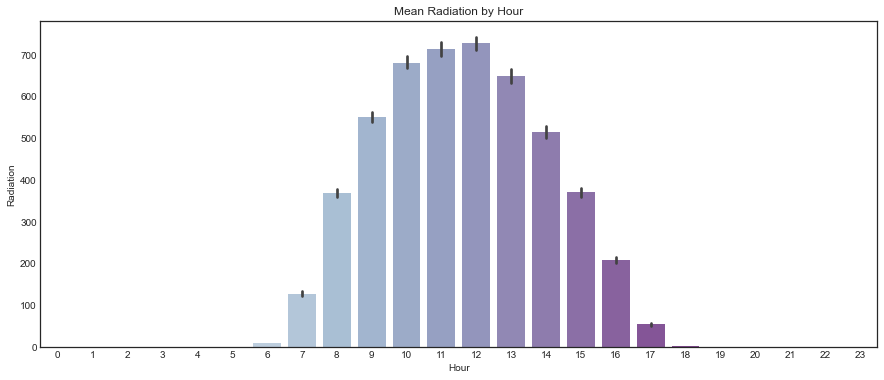

In [77]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(x=df.index.hour, y='Radiation', data=df, palette="BuPu")
ax.set_title('Mean Radiation by Hour');
ax.set_xlabel('Hour')

Text(0.5, 0, 'Day')

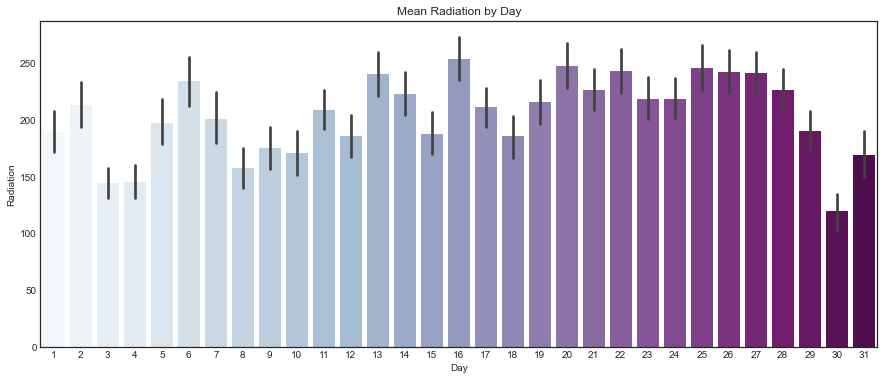

In [78]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(x=df.index.day, y='Radiation', data=df, palette="BuPu")
ax.set_title('Mean Radiation by Day');
ax.set_xlabel('Day')

Text(0.5, 0, 'Month')

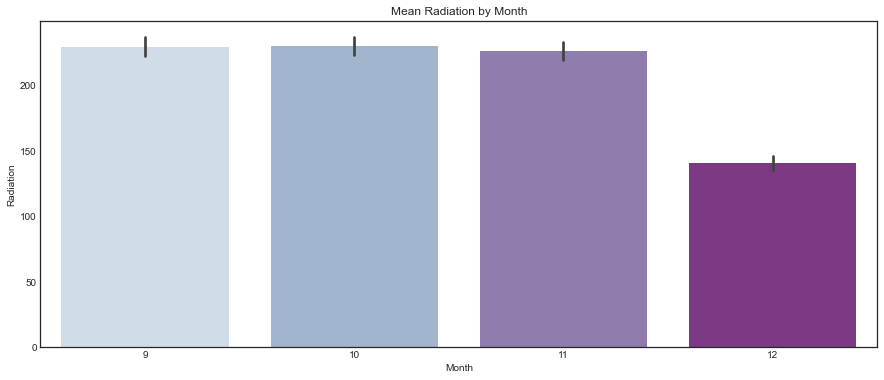

In [79]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(x=df.index.month, y='Radiation', data=df, palette="BuPu")
ax.set_title('Mean Radiation by Month');
ax.set_xlabel('Month')

As expected November and December correspond with a decrease in mean of the Radiation

Text(0.5, 0, 'Month')

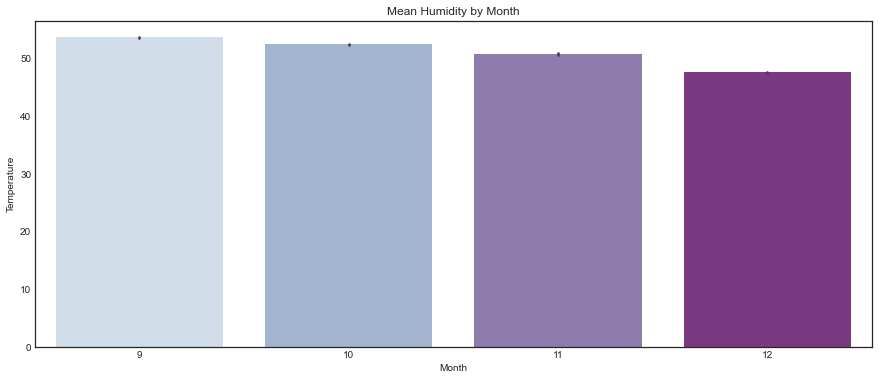

In [80]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(x=df.index.month, y='Temperature', data=df, palette="BuPu")
ax.set_title('Mean Humidity by Month');
ax.set_xlabel('Month')

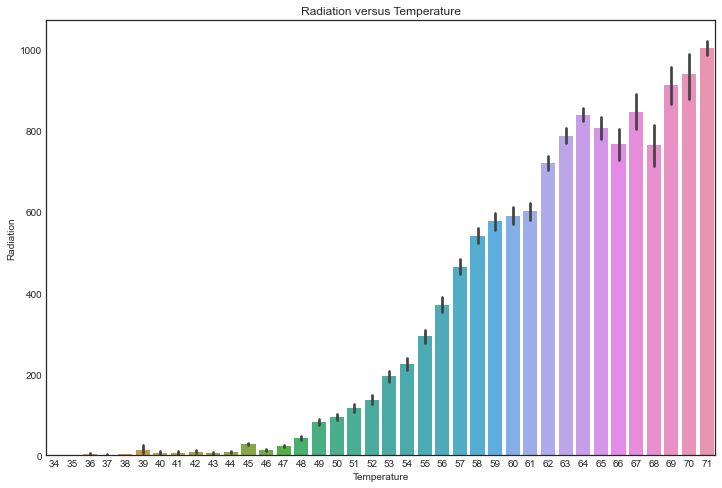

In [81]:
plt.figure(figsize=(12,8))
sns.barplot(x=df.Temperature ,y=df.Radiation)
plt.xlabel('Temperature')
plt.ylabel('Radiation')
plt.title('Radiation versus Temperature')
plt.show()

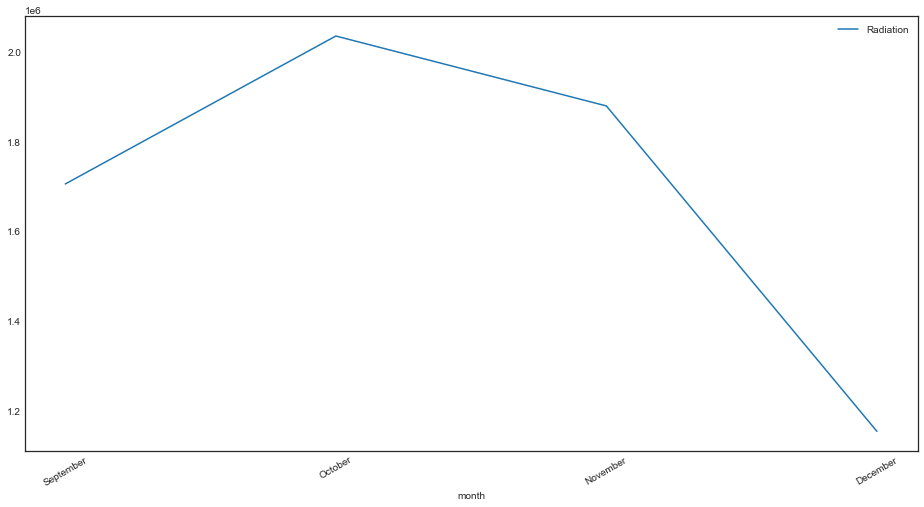

In [82]:
plt.rcParams['figure.figsize'] = (16,8)
months = np.arange(9,13)
rad_vs_month=df.loc[:, ['Radiation', 'month']].groupby('month').sum()
rad_vs_month.plot()
plt.xticks(months,['September', 'October', 'November', 'December'], rotation=30)
plt.show()

We can notice even more clear how the change in seasons influence the radiation values

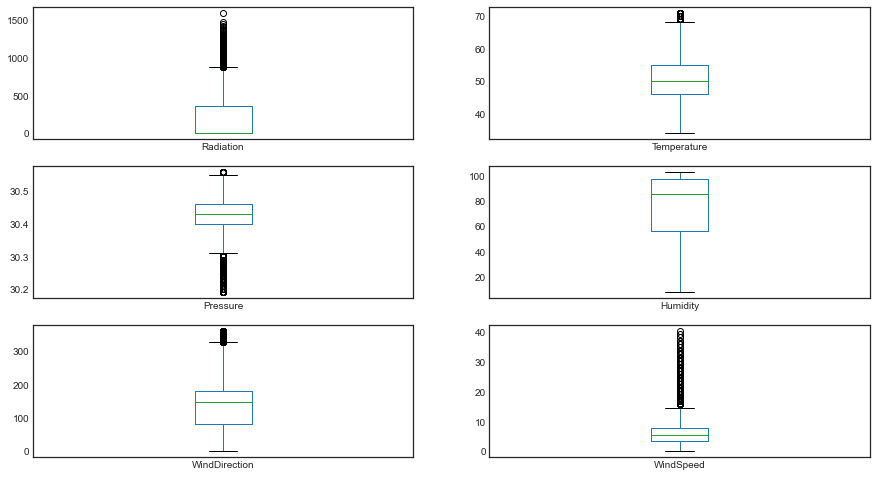

In [83]:
df[['Radiation', 'Temperature', 'Pressure', 'Humidity', 'WindDirection',
       'WindSpeed']].plot(kind="box",subplots=True,layout=(7,2),figsize=(15,20))
plt.show()

Percentage of datapoints considered outlier for Radiation

In [84]:
np.round((df[df['Radiation']>1000]['Radiation'].count())/(len(df['Radiation']))*100,2)

2.01

Percentage of datapoints considered outlier for Windspeed


In [85]:
np.round((df[df['WindSpeed']>15]['WindSpeed'].count())/(len(df['WindSpeed']))*100,2)

1.47

From this exploration of the data, we see the following patterns in this dataset:

- October is the only month without a missing day. On the other hand, December has two days missing whereas September has only one day missing.

- Higher temperatures correlate to more radiation throughput. This is confirmed by a Pearson R-value of 0.72 and the observed behavior of radiation "following" temperature on the daily and weekly time scales.


- Humidity has a lesser (but potentially significant) impact on radiation throughput. With a Pearson R-value of magnitude above 0.20, humidity cannot be ignored as a potential driver of the system.


- Pressure doesn't correlate much to radiation, but does correlate to temperature and humidity. Weather, basically. Since temperature, pressure, and humidity are all characteristics of the atmosphere it is not surprising that they are correlated.


-  Wind direction has a moderate correlation to temperature (-0.26), pressure (-0.23) and radiation (-0.23) but through engineering judgement we know that this is only correlation and not causation.
Seasonal changes are significant. Even though Hawai'i does not see seasons as drastic as the northern continental United States, seasonal changes in temperature and humidity are still severe enough to be taken into account, as shown by the weekly measurement comparisons.


- Month-to-month variation is too broad to capture seasonal changes within a single year. Since day-to-day weather is dominated by temperature, pressure, and humidity (rather than seasonal changes), week of the year is the best indicator of seasonal trends.

## Feature Engineering

In the feature engineering stage we add 5 new columns and remove the outliers.

In [86]:
#extract sunrise and sunrise hour and minute
df['SunriseHour'] = df['TimeSunRise'].apply(lambda x: re.search(r'^\d+', x).group(0)).astype(np.int)
df['SunriseMinute'] = df['TimeSunRise'].apply(lambda x: re.search(r'(?<=:)\d+(?=:)',x).group(0)).astype(np.int)

df['SunsetHour'] = df['TimeSunSet'].apply(lambda x: re.search(r'^\d+', x).group(0)).astype(np.int)
df['SunsetMinute'] = df['TimeSunSet'].apply(lambda x: re.search(r'(?<=:)\d+(?=:)',x).group(0)).astype(np.int)

df['daylight']=df['SunsetHour']-df['SunriseHour']



<ipython-input-86-e2f15af8049f>:2: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

<ipython-input-86-e2f15af8049f>:3: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://

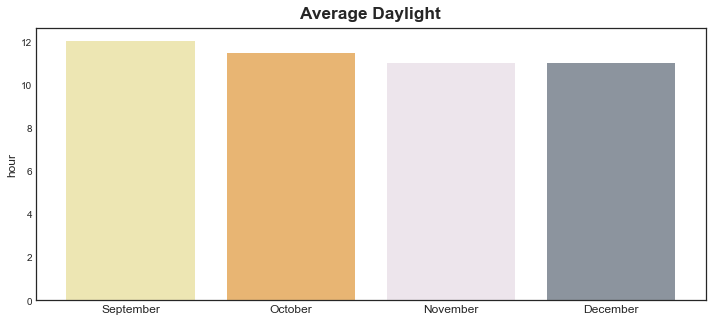

In [87]:
plt.style.use('seaborn-white')
avg_daylight = df.groupby('month')['daylight'].mean()
c = ['#ede6b3', '#e8b573', '#ede5ec', '#8c949e']
plt.figure(figsize=(12,5))
plt.title('Average Daylight',fontsize=12,size = 'xx-large',pad=10,weight = 'bold')
plt.bar(avg_daylight.index, avg_daylight,color=c)
plt.xticks(avg_daylight.index,['September','October','November','December'],fontsize=12)
plt.ylabel('hour',fontsize=12)
plt.show()

September has the highest average daylight whereas December has the lowest average daylight.

### Outlier removal

In [88]:
from sklearn.ensemble import IsolationForest

def outlier_removal(df, ind=-1):

    log_header = ['Radiation','WindSpeed','Pressure']
    print('Before anomaly treatment\n',df[['Radiation','WindSpeed','Pressure']].describe())
    # major parameter percentage of outlier present with parameter contamination, nu : 2 %
    outliers_frac = 0.02
    # define outlier/anomaly detection methods to be compared
    anomaly_algorithm = [('Isolation Forest', IsolationForest(n_estimators=100, max_samples='auto',
                         contamination=outliers_frac, random_state=42))]
        
    fig = plt.figure(figsize=(15, 10))
    fig.subplots_adjust(hspace=0.4, wspace=0.6)
    fig.suptitle('Anomaly detection using Isolation Forest')


# detect anomaly for each features
    for i, item in enumerate(log_header):

        temp = 311+i  # this is to index the position of the subplot
        plt.subplot(temp)
        # Automatic anomaly flagging on whole data sample with inliers labeled as 1 and outliers labeled as -1
        anomaly = anomaly_algorithm[0][1].fit_predict(df[[item]])
        plt.scatter(df.Date, df[item], label='original', marker='o',s=4)
        plt.scatter(df.Date[anomaly==-1], df[item][anomaly==-1], 
                        marker='^', label='outliers',s=4)
        plt.ylabel(item)
        plt.xlabel('Date')
        plt.legend(loc='upper right')
 
        print('\nNumber of anomalies detected for', item, '=', -sum(anomaly[anomaly==-1]),'out of', anomaly.shape[0])
        counter = np.zeros(df.shape[0])
        counter += anomaly

        df = df[anomaly==1]
        print('Number of data points after anomalies removal =',df.shape[0])
    
    print('After anomaly treatment\n',df[['Radiation','WindSpeed','Pressure']].describe())
    return df

Before anomaly treatment
           Radiation     WindSpeed      Pressure
count  32686.000000  32686.000000  32686.000000
mean     207.124697      6.243869     30.422879
std      315.916387      3.490474      0.054673
min        1.110000      0.000000     30.190000
25%        1.230000      3.370000     30.400000
50%        2.660000      5.620000     30.430000
75%      354.235000      7.870000     30.460000
max     1601.260000     40.500000     30.560000

Number of anomalies detected for Radiation = 654 out of 32686
Number of data points after anomalies removal = 32032

Number of anomalies detected for WindSpeed = 467 out of 32032
Number of data points after anomalies removal = 31565

Number of anomalies detected for Pressure = 582 out of 31565
Number of data points after anomalies removal = 30983
After anomaly treatment
           Radiation     WindSpeed      Pressure
count  30983.000000  30983.000000  30983.000000
mean     188.838996      6.021297     30.425183
std      293.445723    

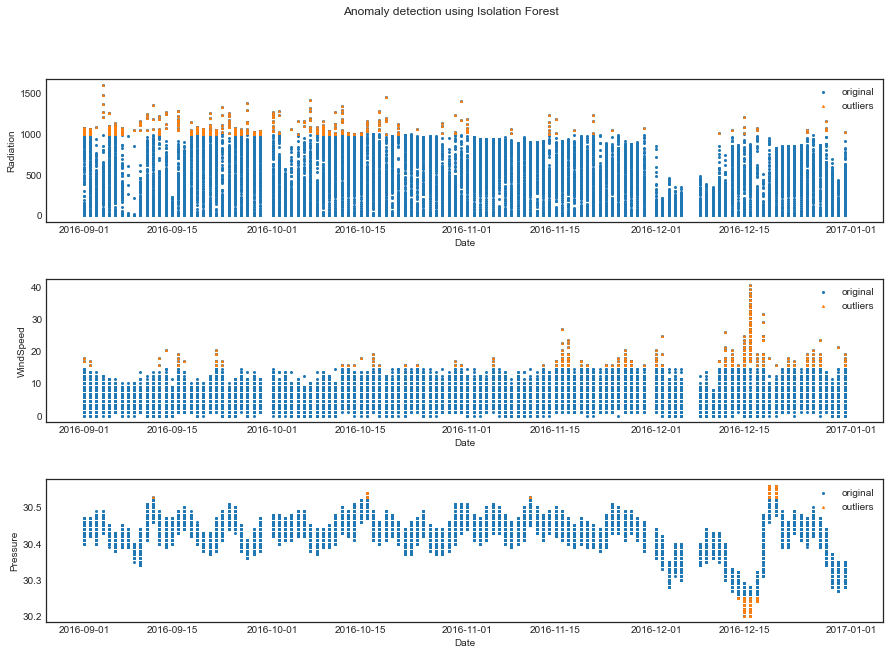

In [89]:
data = outlier_removal(df, ind=-1)

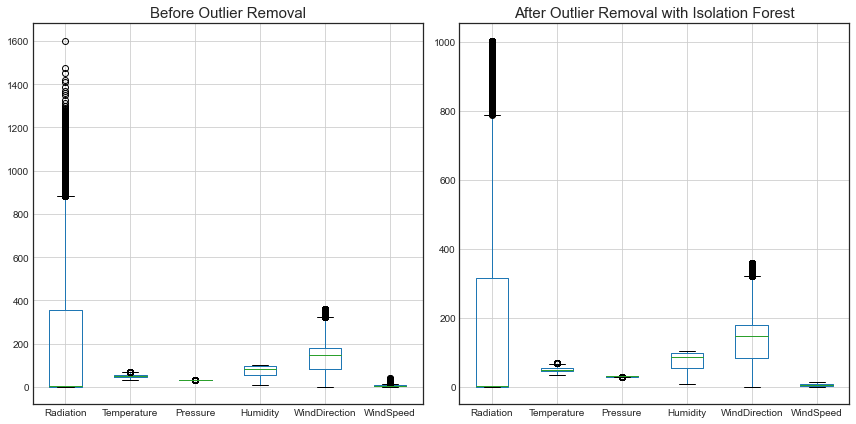

In [90]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
df[['Radiation', 'Temperature', 'Pressure', 'Humidity', 'WindDirection',
       'WindSpeed']].boxplot()
plt.title('Before Outlier Removal', size=15)

plt.subplot(1,2,2)
data[['Radiation', 'Temperature', 'Pressure', 'Humidity', 'WindDirection',
       'WindSpeed']].boxplot()
plt.title('After Outlier Removal with Isolation Forest', size=15)

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Features Correlating with Radiation')

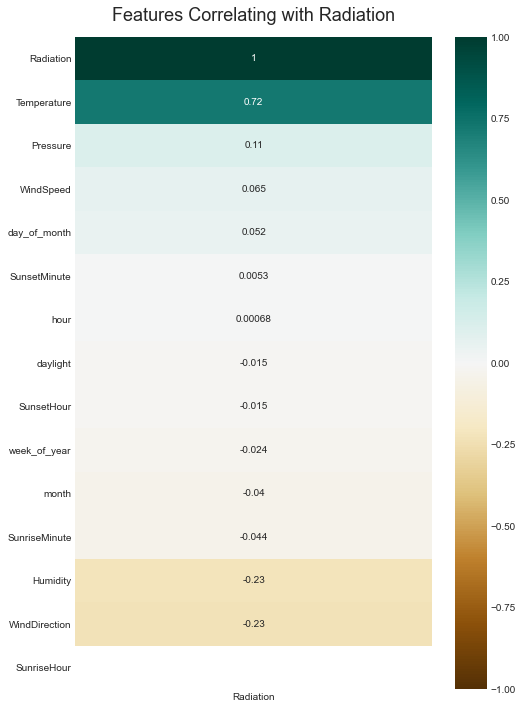

In [91]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(data.corr()[['Radiation']].sort_values(by='Radiation', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Radiation', fontdict={'fontsize':18}, pad=16)

## ML prediction

In [92]:
# Here are some helper functions that will be used for classification
# Some of them are default functions from sklearn library

def benchmark(regressors,train_x_,train_y_,test_x_,test_y_):
  """
  Function to train, fit and predict
  Returns dictionary with classifier information
  """
  results = {}
  for regressor, name in (regressors):
    print('=' * 80)
    print(name)
    print('_' * 80)
    print("Training: ")
    print(regressor)
    t0 = time()
    regressor.fit(train_x_, train_y_)
    train_time = str(time() - t0)
    print(f"train time: {train_time}" )
    t0 = time()
    pred = regressor.predict(test_x_)
    test_time = str(time() - t0)
    print(f"test time:  {test_time}")
    #score = mean_squared_error(test_y_, pred)
    score = r2_score(test_y_, pred)
    print("R2: ", score)

    results.update({name:[regressor.get_params(), score, train_time, test_time]})
  return results
  
def plt_reg(results,title="Score"):
  """
  Function for plotting the score and time of classifiers
  """
  indices = np.arange(len(results))
  name = [i for i in results]
  score = [j[1] for j in [results[i] for i in results]]
  training_time = [j[2] for j in [results[i] for i in results]]
  test_time = [j[3] for j in [results[i] for i in results]]
  training_time_ind = np.array(training_time).astype(np.float)
  test_time_ind = np.array(test_time).astype(np.float)
  training_time_ind = training_time_ind / np.max(training_time_ind)
  test_time_ind = test_time_ind / np.max(test_time_ind)
  plt.figure(figsize=(12, 8))
  plt.title(title)
  plt.barh(indices, score, .2, label="Score", color='navy')
  plt.barh(indices + .3, training_time_ind, .2, label="Training time", color='c')
  plt.barh(indices + .6, test_time_ind, .2, label="Test time", color='darkorange')
  plt.yticks(())
  plt.legend(loc='best')
  plt.subplots_adjust(left=.25)
  plt.subplots_adjust(top=.95)
  plt.subplots_adjust(bottom=.05)
  for i in indices:
    plt.text(-.3, i,  f"{name[i]}\n"
                      f"Score: {np.round(score[i],8)}\n"
                      f"Training time: {np.round(float(training_time[i]),2)}\n"
                      f"Test time: {np.round(float(test_time[i]),2)}")
  plt.show()


def gridsearch(pipe,para,train_x_,train_y_, cv = 5, plot=True):
  """
  Function gridsearch
  """
  stopwatch = datetime.now()
  grid = GridSearchCV(pipe, para, n_jobs=-1, verbose=1, cv = cv, return_train_score=True)#, scoring="accuracy")
  #grid = RandomizedSearchCV(pipe, para, n_jobs=-1, verbose=1, cv = cv, return_train_score=True,random_state=101)#, scoring="accuracy")
  grid.fit(train_x_,train_y_)

  #metric_names = ['f1', 'roc_auc', 'average_precision', 'accuracy', 'precision', 'recall']
  grid_results={}
  para = []
  paraname= []
  for i,k in enumerate(list(zip(*grid.param_grid.items()))[1]):
    if len(k)>1:
      para.append(k)
      paraname.append((list(zip(*grid.param_grid.items()))[0][i]))
  #longest=max((len(l), i) for i, l in enumerate(para))[1]
  secondlongest = 0
  if len(para) >1:
    secondlongest = [len(i) for i in para]
    secondlongest.remove(sorted(secondlongest)[-1])
    secondlongest = np.argmax(secondlongest)
  
  for i,dic in enumerate(grid.cv_results_["params"]):
    score = grid.cv_results_["mean_test_score"][i]
    train_time = grid.cv_results_["mean_fit_time"][i]
    test_time = grid.cv_results_["mean_score_time"][i]
    title ,name= "",""
    for k,v in dic.items():
      if k in paraname:
        ksplit = k.split(grid.estimator.steps[-1][0]+"__")[-1]+" :"+str(v)+" "
        if len(para) >1 and  sum((len(l)) for l in para) >4:
          if k == paraname[secondlongest]:
            title=f"Result grouped by {ksplit}"
            continue
        else:
          title="Result"
        name += ksplit
    if title not in grid_results:
        grid_results.update({title:[[name, score, train_time, test_time,name]]})
    else:
      grid_results[title].append([name, score, train_time, test_time,name])
  if plot:
    for i in grid_results:
      p={}
      for j,k in enumerate(grid_results[i]):
        p.update({k[0]:k})
      print("_"*100)
      plt_reg(p,f"{i}")
      print("_"*100)         
  print("Best score: {:.2f}".format(grid.best_score_))
  print("Best parameters: ", grid.best_params_)
  print(f"Time: {datetime.now() - stopwatch}")
  #return grid
  return (grid.best_estimator_[-1].get_params())

In [93]:
# Splitting data and selecting columns we want to use for classification

# Choose which features you want to pass as X in the sklearn ML algoritms

columns = ['Temperature', 'Pressure', 'Humidity',
          'WindDirection', 'WindSpeed', 
          'hour', 'SunriseMinute', 'SunsetMinute']
X = data[columns]
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

# and then divide the entire dataset in test and train, here we use 30% as test data with shuffling
train_x, test_x, train_y, test_y = train_test_split(X, data["Radiation"], test_size=0.3, random_state=101, shuffle=True)

In [94]:
# Here we choose ML algoritms from sklearn and compare them, can also specify parameters inside each function

regressors = [

           (GradientBoostingRegressor(), "GradientBoosting"),

           (XGBRegressor(), "XGBregressor"),

           (LinearRegression(), "LinearRegression"),

           (RandomForestRegressor(max_depth=10), "Random forest"),

           (DecisionTreeRegressor(max_depth=10), "Decision Tree"),

           (LinearSVR(), "Linear SVR")
]
results = benchmark(regressors[::-1],train_x, train_y, test_x, test_y)

Linear SVR
________________________________________________________________________________
Training: 
LinearSVR()
train time: 0.06128048896789551
test time:  0.00524592399597168
R2:  0.5956847339394613
Decision Tree
________________________________________________________________________________
Training: 
DecisionTreeRegressor(max_depth=10)
train time: 0.2525138854980469
test time:  0.008688926696777344
R2:  0.9120763626545032
Random forest
________________________________________________________________________________
Training: 
RandomForestRegressor(max_depth=10)
train time: 6.259181022644043
test time:  0.23197126388549805
R2:  0.9263600311670732
LinearRegression
________________________________________________________________________________
Training: 
LinearRegression()
train time: 0.03724026679992676
test time:  0.0029740333557128906
R2:  0.6199805597518008
XGBregressor
________________________________________________________________________________
Training: 
XGBRegressor(bas

<ipython-input-92-d6898373396a>:40: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

<ipython-input-92-d6898373396a>:41: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



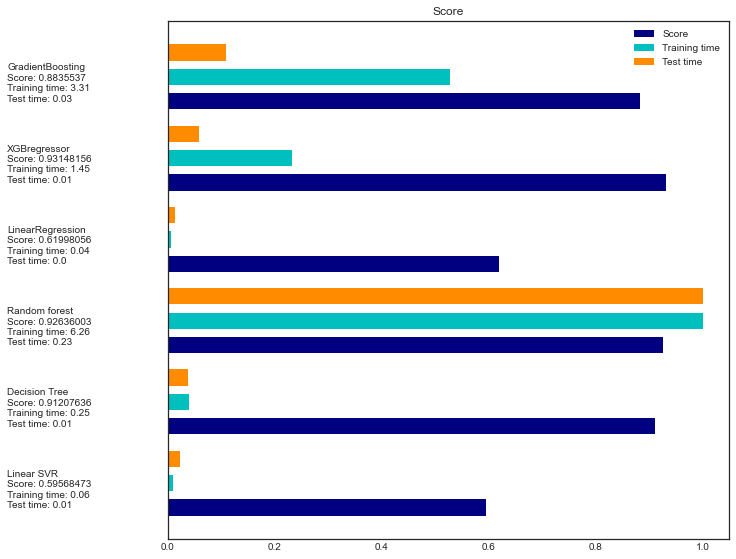

In [95]:
# This simple function from standard library for plotting results

plt_reg(results)

### Hyperparameter tuning

In this stage we tune the parameters by using gridsearch function defined above, which uses built in sklearn gridsearch.
Note which ways parameters are written, we see that for random forest we managed to inprove from 92 to 93.

In [40]:
from datetime import datetime

Fitting 3 folds for each of 32 candidates, totalling 96 fits
____________________________________________________________________________________________________


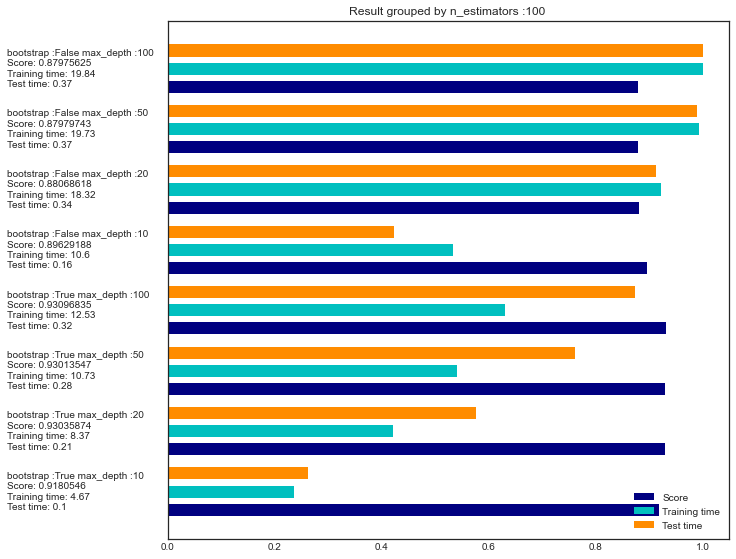

____________________________________________________________________________________________________
____________________________________________________________________________________________________


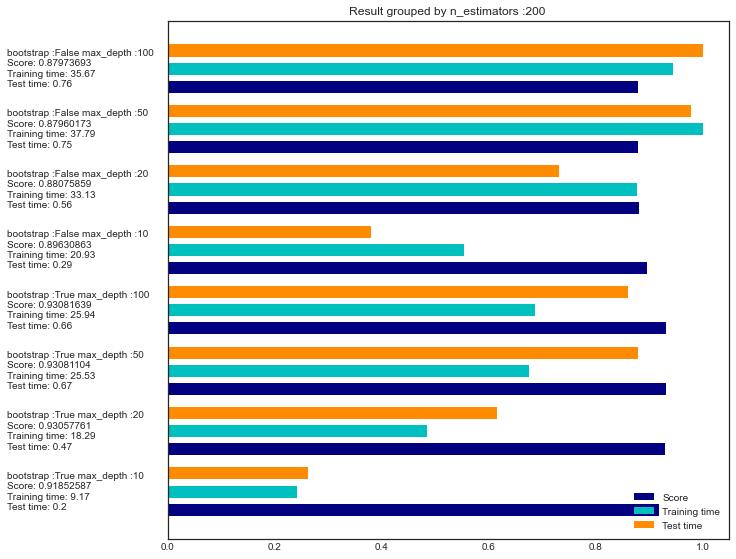

____________________________________________________________________________________________________
____________________________________________________________________________________________________


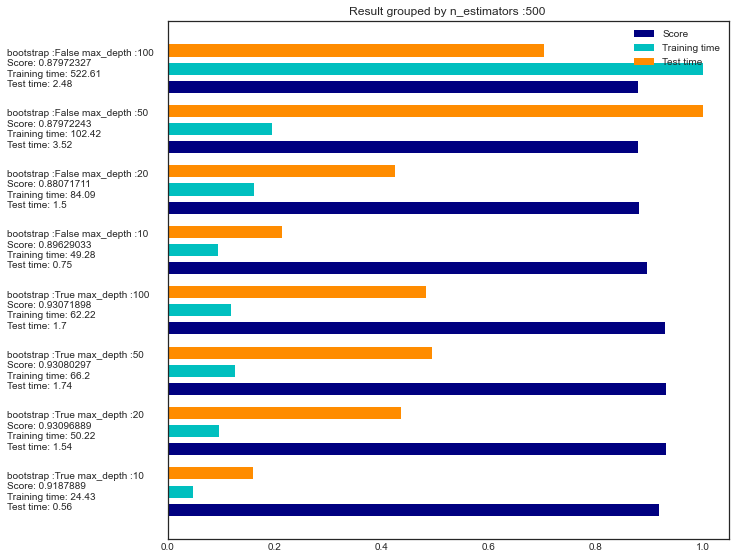

____________________________________________________________________________________________________
____________________________________________________________________________________________________


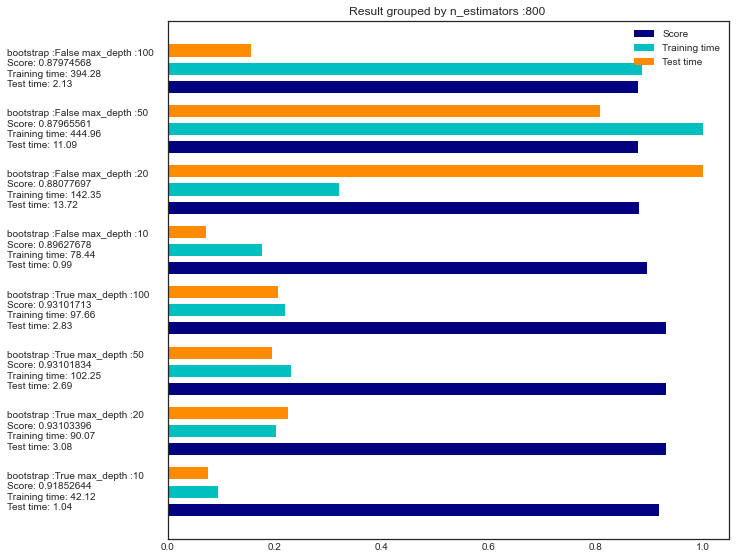

____________________________________________________________________________________________________
Best score: 0.93
Best parameters:  {'Rf__bootstrap': True, 'Rf__max_depth': 20, 'Rf__n_estimators': 800}
Time: 0:20:00.294434


In [47]:
cv = 3

pipeline = Pipeline(steps=[
  ("Rf", RandomForestRegressor())
  ])

parameters = {"Rf__n_estimators": [100,200,500,800],
              "Rf__max_depth": [10,20,50,100],
              "Rf__bootstrap": [True,False]}

RandomForest_Grid = gridsearch(pipeline,parameters,train_x,train_y, cv = cv)

## RandomizedSearchCV

We also tested RandomizedSearchCV since it is less computationally expensive than GridSearchCV.

By adding more parameters we managed to increase the performance of the model 2%.

In [ ]:
# random_grid = {'n_estimators': np.arange(500, 700, 10),
#                'max_features': np.arange(5,8),
#                'max_depth': np.arange(10, 25),
#                'min_samples_split': [1, 2, 3, 4,5],
#                'min_samples_leaf': [1, 2, 3, 4,5],
#                'n_jobs': [-1]}

# RFR = RandomForestRegressor()
# random_search = RandomizedSearchCV(RFR, param_distributions=random_grid, n_iter=25, 
#                                    scoring='r2', n_jobs=-1, refit=False)
# random_search.fit(features, label)


In [ ]:
# random_search.best_params_

In [97]:

best_random = RandomForestRegressor(max_depth=16,max_features= 6,
                                    min_samples_leaf=3, min_samples_split=5,
                                    n_estimators=670, n_jobs=-1,
                                    random_state=None)
best_random.fit(train_x, train_y)

label_pred = best_random.predict(test_x)

r_squared = r2_score(test_y, label_pred)
print('r2 =', r_squared)

r2 = 0.939727413166415


C:\Users\ndani\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



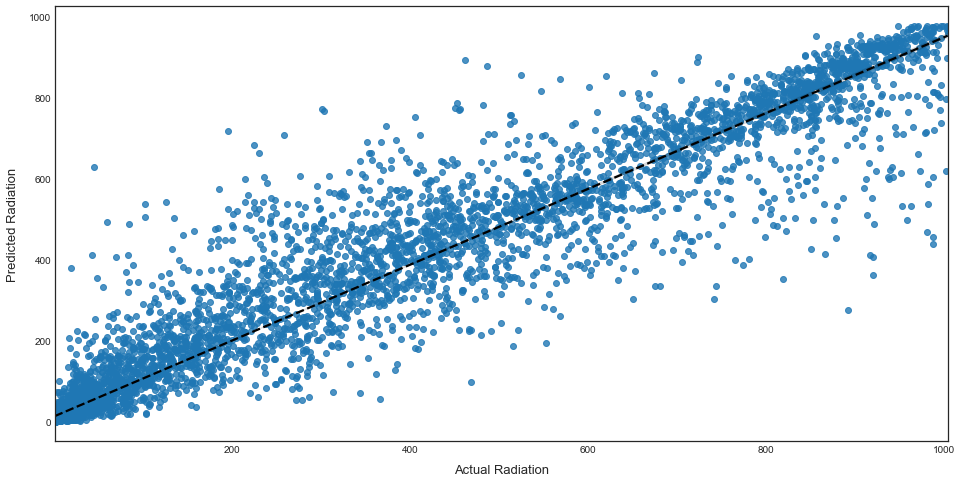

In [104]:
sns.regplot(test_y, 
            label_pred, line_kws={"color": "black","linestyle":'--'})
plt.xlabel('Actual Radiation',size=13,labelpad = 10)
plt.ylabel('Predicted Radiation',size=13,labelpad = 10)
plt.grid(False)

We can also get an overview of the features that contributed the most and the least in the optimized model

Feature ranking:
1. feature 0 (0.479460)
2. feature 5 (0.305525)
3. feature 3 (0.075553)
4. feature 2 (0.065408)
5. feature 6 (0.030945)
6. feature 7 (0.021726)
7. feature 1 (0.014664)
8. feature 4 (0.006719)


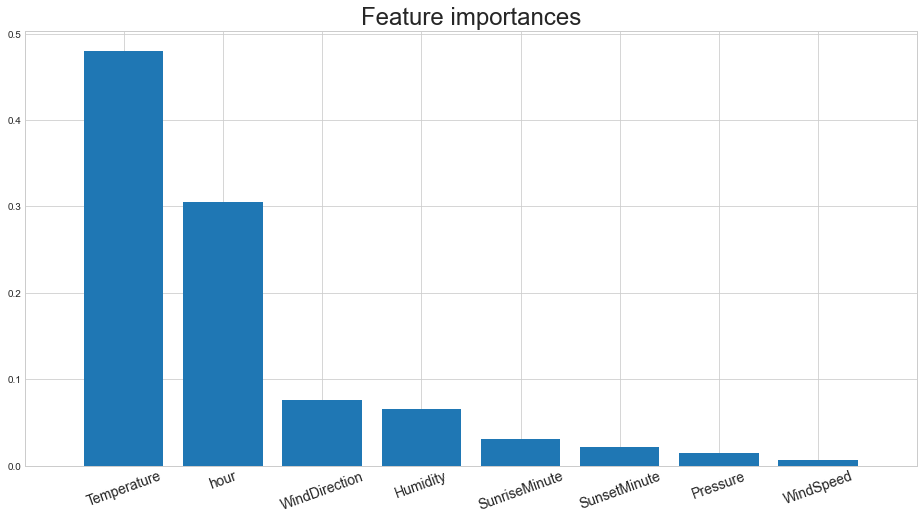

In [105]:
plt.style.use('seaborn-whitegrid')
X = df[columns]
#label for x-axis
features_name = np.array(X.columns.values)
features_name

importances = best_random.feature_importances_
std = np.std([best_random.feature_importances_ for tree in best_random.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")

for f in range(train_x.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances 
plt.figure()
plt.title("Feature importances",size=24)
plt.bar(range(train_x.shape[1]), importances[indices],
      yerr=std[indices], align="center")
plt.xticks(range(train_x.shape[1]), features_name[indices],rotation=20,fontsize = 14)
plt.xlim([-1, train_x.shape[1]])
plt.show()

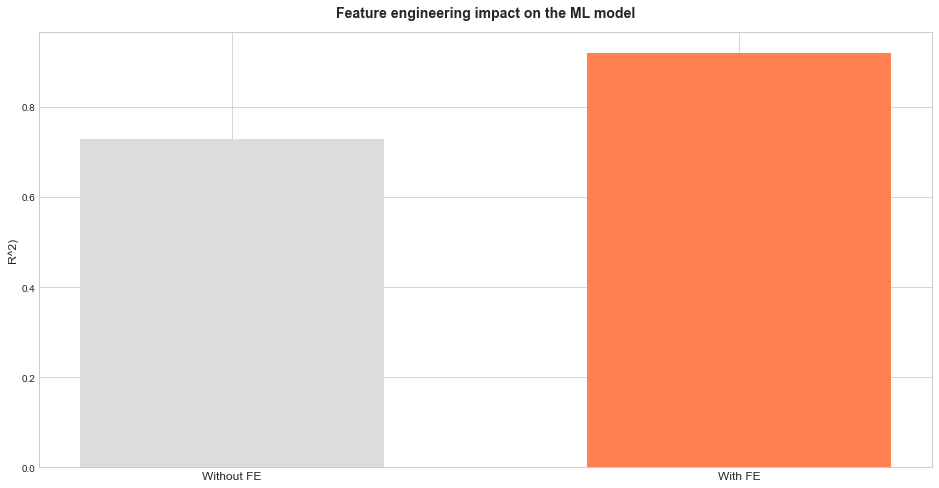

In [125]:

x = ['Without FE', 'With FE']
r_squared = [0.73, 0.92]
colors = ['#DCDCDC','#ff7f50']
x_labels = [i for i, _ in enumerate(x)]

plt.bar(x_labels, r_squared, width=0.6, color = colors)
plt.ylabel("R^2)",fontsize=12)
plt.title("Feature engineering impact on the ML model", fontsize=14, weight='bold', pad=15)

plt.xticks(x_labels, x,fontsize=12)

plt.show()

## ANN


In [40]:
# function to make results more understanding, squared root of mse

def rmse(y_act,pred):
    return K.sqrt(K.mean(K.square(y_act - pred)))



In [46]:
model = tf.keras.models.Sequential()
inp = train_x.shape[1]
model.add(tf.keras.layers.Dense(units = 64, activation='tanh', input_shape=[inp,]))
model.add(tf.keras.layers.Dense(units = 128, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.Dropout(0.4)) #for overfitting
model.add(tf.keras.layers.Dense(units = 64, activation='tanh'))
model.add(tf.keras.layers.Dropout(0.1)) #for overfitting
model.add(tf.keras.layers.Dense(units=1, activation='linear'))
learning_rt = 0.001 #best seems to be 0.001 for adam
opt = tf.optimizers.Adam(learning_rt)
model.compile(optimizer=opt, loss= rmse, metrics=[rmse])

# Changing regularization parameter did not alter big results, kept at 0.001
# No major difference between Adam and Sgd, Adam slightly better
# 0.001 seems to be the best lerning rate for the model
# Adding droput layer definately reduced overfitting
# Both Tanh and Relu give best results for hidden layers with Relu being slightly better
# We see that overfitting increases after 100 epochs. For that reason added extra drop out before output layer

learn_hist = model.fit(train_x, train_y,epochs = 500, verbose=0, validation_data=(test_x,test_y))

In [48]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error ')
  plt.legend()
  plt.grid(True)

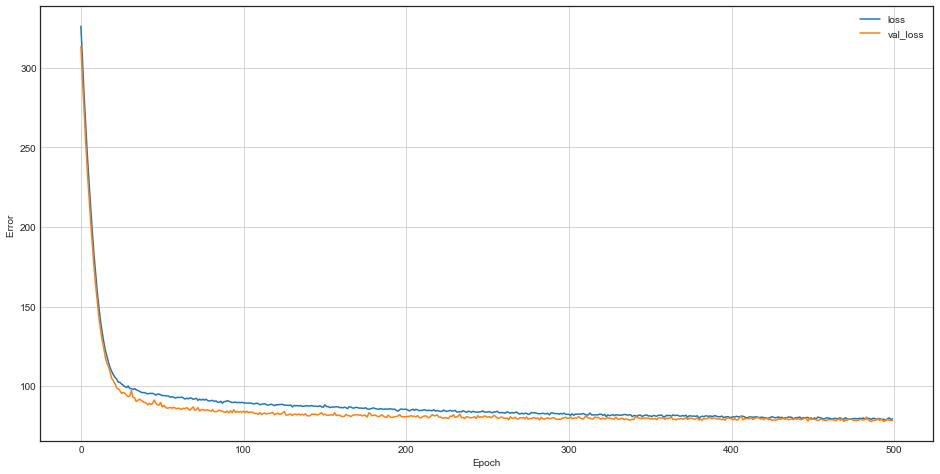

In [49]:
plot_loss(learn_hist)

# plotting learning curves for train and test

In [50]:
test_data = model.evaluate(test_x,test_y)

# validating with test set

291/291 [==============================] - 1s 2ms/step - loss: 78.4355 - rmse: 76.7553


In [51]:
# predicting random 10 values from test set

indicies = random.sample(range(1,9000), 10)
predictions = model.predict(test_x[indicies,])
actual = test_y[indicies]
pr = pd.DataFrame(predictions,actual)
pr

0
Radiation            
1.19         4.837366
1.82         4.837366
132.43     567.411865
89.24      152.727478
893.72     874.898010
1.22         4.837366
1.25         4.837366
796.00     570.003174
1.17         5.243288
859.10     818.840942

## Conclusions

- Data preprocessing is a critical step in Machine Learning.

- EDA was important in discovering patterns, spotting anomalies,and checking assumptions in the dataset. Similarly, we found that 4 days are missing and this could be related to technical issue (sensor?)

- Adding engineered features to the model such as ***hour***, ***SunriseMinute***, ***SunsetMinute*** improved the test set performance almost ~20% (from 73 to 92). On the other hand, removing the outliers only added a minimal improvement (1%).

- Random Forest and XGboost, which can handle high dimensional and complex data structures are the highest performing algorithms whereas linear regression has the worst performance which is expected since the data is not linear. Similarly, ANN was tested with moderate success.

- Hyperparameter tuning was performed using GridSearchCV and RandomizedSearchCV and contributed to 1 and 2% improvement in the final model
